In [1]:
import pickle
import json
import numpy as np
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from __future__ import annotations
import os
import logging
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import time

import torch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

# https://python.langchain.com/en/latest/modules/indexes/document_loaders/examples/excel.html?highlight=xlsx#microsoft-excel
from langchain.document_loaders import (
    CSVLoader,
    PDFMinerLoader,
    TextLoader,
    UnstructuredExcelLoader,
    Docx2txtLoader,
)

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma, FAISS

[nltk_data] Error loading omw: <urlopen error [Errno 101] Network is
[nltk_data]     unreachable>
[nltk_data] Error loading wordnet: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>


In [2]:
import os
INGEST_THREADS = os.cpu_count() or 8
def load_single_document(file_path: str) -> Document:
    # Loads a single document from a file path
    file_extension = os.path.splitext(file_path)[1]
    loader_class = DOCUMENT_MAP.get(file_extension)
    if loader_class == TextLoader:
        loader = TextLoader(file_path, encoding="utf-8")
    elif loader_class:
        loader = loader_class(file_path)
    else:
        raise ValueError("Document type is undefined")
    return loader.load()[0]
DOCUMENT_MAP = {
    ".txt": TextLoader,
    ".md": TextLoader,
    ".pdf": PDFMinerLoader,
    ".csv": CSVLoader,
    ".xls": UnstructuredExcelLoader,
    ".xlsx": UnstructuredExcelLoader,
    ".docx": Docx2txtLoader,
    ".doc": Docx2txtLoader,
}
def load_document_batch(filepaths):
    logging.info("Loading document batch")
    # create a thread pool
    with ThreadPoolExecutor(len(filepaths)) as exe:
        # load files
        futures = [exe.submit(load_single_document, name) for name in filepaths]
        # collect data
        data_list = [future.result() for future in futures]
        # return data and file paths
        return (data_list, filepaths)
def loadDocuments(
    source_dir: str, chunk_size=1000, chunk_overlap=200
) -> list[Document]:
    # Loads all documents from the source documents directory, including nested folders
    paths = []
    for root, _, files in os.walk(source_dir):
        for file_name in files:
            file_extension = os.path.splitext(file_name)[1]
            source_file_path = os.path.join(root, file_name)
            if file_extension in DOCUMENT_MAP.keys():
                paths.append(source_file_path)

    # Have at least one worker and at most INGEST_THREADS workers
    n_workers = min(INGEST_THREADS, max(len(paths), 1))
    # chunksize = round(len(paths) / n_workers)
    chunksize = max(round(len(paths) / n_workers), 1)
    docs = []
    with ProcessPoolExecutor(n_workers) as executor:
        futures = []
        # split the load operations into chunks
        for i in range(0, len(paths), chunksize):
            # select a chunk of filenames
            filepaths = paths[i : (i + chunksize)]
            # submit the task
            future = executor.submit(load_document_batch, filepaths)
            futures.append(future)
        # process all results
        for future in as_completed(futures):
            # open the file and load the data
            contents, _ = future.result()
            docs.extend(contents)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    documents: list[Document]
    documents = text_splitter.split_documents(docs)
    # documents = char_data_splitter(docs, chunk_size, chunk_overlap)
    return documents


In [3]:
endl = "\n"

In [4]:
#load_dotenv()
import re
# root_dir = "."
# sys.path.append(root_dir)  # if import module in this project error
if os.name != "nt":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
# %% [markdown]
###**setup var**

#%%
#chunk_size = 2000
# chunk_overlap = 200
# embedding_algorithm = "faiss"
# source_directory = f"{root_dir}/ir-service/docs"
# persist_directory = f"{root_dir}/ir-service/tmp/embeddings/{embedding_algorithm}"
# print(root_dir)
# print(persist_directory)

# Original mapper dictionary
mapper = {
    "law_doc-84-89.txt": "761/2566",
    "law_doc-44-46.txt": "1301/2566",
    "law_doc-54-57.txt": "1225/2566",
    "law_doc-12-13.txt": "2525/2566",
    "law_doc-40-43.txt": "1305/2566",
    "law_doc-14-15.txt": "2085/2566",
    "law_doc-64-69.txt": "1090/2566",
    "law_doc-1-5.txt": "2610/2566",
    "law_doc-78-81.txt": "882/2566",
    "law_doc-82-83.txt": "835/2566",
    "law_doc-35-39.txt": "1306/2566",
    "law_doc-16-20.txt": "1574/2566",
    "law_doc-32-34.txt": "1373/2566",
    "law_doc-74-77.txt": "934/2566",
    "law_doc-6-11.txt": "2609/2566",
    "law_doc-90-92.txt": "756/2566",
    "law_doc-47-53.txt": "1300/2566",
    "law_doc-58-63.txt": "1101/2566",
    "law_doc-70-73.txt": "1003/2566",
    "law_doc-21-31.txt": "1542/2566",
}

# Reverse the mapping and format it
mapper_reverse = {f"คดี {case}": filename for filename, case in mapper.items()}

endl = "\n"
# print(root_dir)
exclude_pattern = re.compile(r"[^ก-๙]+")  # |[^0-9a-zA-Z]+

In [5]:
import sys
root_dir = os.path.dirname(os.getcwd())
# sys.path.append(os.path.join(root_dir, 'deployment/ir-trt-service'))

In [6]:
contents = None
documents_specific = None
documents_general = None
documents = None


if contents is None:
    with open("/home/shanwibo/Capstone-TamTanai/notebooks/specific_case_knowledge.txt", "r", encoding="utf-8") as f:
        content = f.read()
    contents = content.split("\n\n")

    if documents_specific is None:
        documents_specific = [
            Document(
                page_content=f"{endl.join(c.split(endl)[1:])}",
                metadata={
                    "source": f"docs/{mapper_reverse[c.split(endl)[0]]}",
                    "category": "specific",
                },
            )
            for c in contents
        ]
if documents_general is None:
    # documents_general = loadDocuments(
    #         source_dir=f"/home/shanwibo/Capstone-TamTanai/asset/documentation", chunk_size=10e14, chunk_overlap=0
    #     )
    documents_general = loadDocuments(
            source_dir=f"/home/shanwibo/Capstone-TamTanai/asset/documentation", chunk_size=10e14, chunk_overlap=0
        )
    for i in range(len(documents_general)):
        documents_general[i].metadata["source"] = (
                documents_general[i].metadata["source"].replace(f"{root_dir}/", "")
            )
        documents_general[i].metadata["category"] = "general"
if documents is None:
    documents = documents_general + documents_specific

In [7]:
documents_text = []
for i in range (len(documents)) :
    documents_text.append(documents[i].page_content)

In [8]:
from langchain_community.embeddings import SentenceTransformerEmbeddings
#reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)
def load_embedding_model(embedding_model_name="/project/lt200301-edubot/Capstone-TamTanai/models/multilingual-e5-large"):

    if torch.cuda.is_available():
        device_type = "cuda"
    # elif torch.backends.mps.is_available():
    #     device_type = "mps"
    else:
        device_type = "cpu"
    #embeddings = SentenceTransformerEmbeddings(model_name="infloat/multilingual-e5-large-instruct", model_kwargs={"trust_remote_code":True})
    embeddings = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device_type}
    )
    return embeddings

def embed_database(
    documents,
    persist_directory,
    embedding_model_name="/project/lt200301-edubot/Capstone-TamTanai/models/multilingual-e5-large",
    vector_store="faiss",
):

    embeddings = load_embedding_model(embedding_model_name)

    # Embedding temp exists
    if os.path.isdir(persist_directory):
        if vector_store == "faiss":
            vectordb = FAISS.load_local(
                persist_directory, embeddings,allow_dangerous_deserialization=True
            )
        elif vector_store == "chroma":
            vectordb = Chroma(
                embedding_function=embeddings, persist_directory=persist_directory
            )
            vectordb.persist()
        else:
            raise NotImplementedError(
                f"Embedding Algorithm {vector_store} is not supported/implemented"
            )

    # Create embeddings if not exists
    else:
        if vector_store == "faiss":
            vectordb = FAISS.from_documents(
                documents=documents,
                embedding=embeddings
            )
            vectordb.save_local(persist_directory)
        elif vector_store == "chroma":
            vectordb = Chroma.from_documents(
                documents=documents,
                embedding=embeddings,
                persist_directory=persist_directory,
            )
            vectordb.persist()
        else:
            raise NotImplementedError(
                f"Embedding Algorithm {vector_store} is not supported/implemented"
            )

    return vectordb

# def reranker(question,doc):
#     reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)
#     check = []
#     for i in range (len(doc)) :
#         check.append([question,doc[i].page_content])
#     score = reranker.compute_score(check)
#     return doc[score.index(max(score))].page_content

In [9]:
persist_directory = "./vectordb"
vectordb = embed_database(documents=documents, persist_directory=persist_directory)
question = "ขอดูอย่างคดีที่มีการพิพากษาของศาลฎีกาต่างจากศาลอุทธรณ์หน่อยได้ไหมครับ"
retriever= vectordb.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5})
retrieved_docs = retriever.get_relevant_documents(question)
print(len(retrieved_docs))

/tmp/ipykernel_1184/693222390.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(
/tmp/ipykernel_1184/31157291.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  retrieved_docs = retriever.get_relevant_documents(question)


4


# Utils

In [10]:
from pythainlp import word_tokenize, pos_tag
from pythainlp.corpus.common import thai_stopwords
import nltk
from nltk.corpus import stopwords


if os.name != "nt":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
# %% [markdown]
###**setup var**

#%%
#chunk_size = 2000
# chunk_overlap = 200
# embedding_algorithm = "faiss"
# source_directory = f"{root_dir}/ir-service/docs"
# persist_directory = f"{root_dir}/ir-service/tmp/embeddings/{embedding_algorithm}"
# print(root_dir)
# print(persist_directory)

# Original mapper dictionary
mapper = {
    "law_doc-84-89.txt": "761/2566",
    "law_doc-44-46.txt": "1301/2566",
    "law_doc-54-57.txt": "1225/2566",
    "law_doc-12-13.txt": "2525/2566",
    "law_doc-40-43.txt": "1305/2566",
    "law_doc-14-15.txt": "2085/2566",
    "law_doc-64-69.txt": "1090/2566",
    "law_doc-1-5.txt": "2610/2566",
    "law_doc-78-81.txt": "882/2566",
    "law_doc-82-83.txt": "835/2566",
    "law_doc-35-39.txt": "1306/2566",
    "law_doc-16-20.txt": "1574/2566",
    "law_doc-32-34.txt": "1373/2566",
    "law_doc-74-77.txt": "934/2566",
    "law_doc-6-11.txt": "2609/2566",
    "law_doc-90-92.txt": "756/2566",
    "law_doc-47-53.txt": "1300/2566",
    "law_doc-58-63.txt": "1101/2566",
    "law_doc-70-73.txt": "1003/2566",
    "law_doc-21-31.txt": "1542/2566",
}

# Reverse the mapping and format it
mapper_reverse = {f"คดี {case}": filename for filename, case in mapper.items()}

endl = "\n"
# print(root_dir)
exclude_pattern = re.compile(r"[^ก-๙]+")  # |[^0-9a-zA-Z]+


def is_exclude(text):
    return bool(exclude_pattern.search(text))


key_tags = ["NCMN", "NCNM", "NPRP", "NONM", "NLBL", "NTTL"]

thaistopwords = list(thai_stopwords())
nltk.download("stopwords")


def remove_stopwords(text):
    res = [
        word.lower()
        for word in text
        if (word not in thaistopwords and word not in stopwords.words())
    ]
    return res


def keyword_search(question, idf):
    tokens = word_tokenize(question, engine="newmm", keep_whitespace=False)
    pos_tags = pos_tag(tokens)
    noun_pos_tags = []
    for e in pos_tags:
        if e[1] in key_tags:
            noun_pos_tags.append(e[0])
    noun_pos_tags = remove_stopwords(noun_pos_tags)
    if idf:
        noun_pos_tags = [word for word in noun_pos_tags if word != 'มาตรา' or 'มาตรา' not in word]
    noun_pos_tags = list(set(noun_pos_tags))
    return noun_pos_tags


# %%

def remove_duplicated_documents(documents):
    sources = [doc.metadata['source'] for doc in documents]
    unique_indices = []
    seen = set()
    for index, value in enumerate(sources):
        if value not in seen:
            unique_indices.append(index)
            seen.add(value)
    return list(np.array(documents)[unique_indices])


def find_case_number(text):
    pattern = re.compile(r"(?<!\d)(\d{1,5}/\d{4})(?!\d)")
    match = re.findall(pattern, text)
    if pattern.search(text) and all(e in mapper.values() for e in match):
        return [True, match]
    else:
        return [False, ""]


def find_law_number(text):
    pattern = re.compile(r'มาตรา ?(\d+(?:/\d+)?)\s*(ทวิ|ตรี|จัตวา|เบญจ|ฉ|สัตต|อัฏฐ|นว|ทศ|เอกาทศ|ทวาทศ|เตรส|จตุทศ|ปัณรส|โสฬส|สัตตรส|อัฏฐารส)?')
    match = re.findall(pattern, text)
    result = []
    for m in match:
        result.append(f'มาตรา {m[0]} {m[1]}'.strip())
    if result:
        return [True, result]
    else:
        return [False, ""]


def keyword_matcher(doc, keywords):
    matched_keywords = []
    for keyword in keywords:
        pattern = re.compile(re.escape(keyword))
        if pattern.search(doc.page_content):
            matched_keywords.append(keyword)
    return matched_keywords


def filter_docs_by_keywords(docs, keywords, question, case_number=True, law_number=True):
    if not keywords:
        return [], []
    filtered_docs = []
    matches = []
    found_case_number = False
    found_law_number = False
    if case_number:
        found_case_number, case_numbers = find_case_number(question)
    if law_number:
        found_law_number, law_numbers = find_law_number(question)
    for doc in docs:
        if found_case_number:
            for case_number in case_numbers:
                pattern = re.compile(re.escape(case_number))
                if pattern.search(doc.page_content):
                    matched_keywords = keyword_matcher(doc, keywords)
                    if len(matched_keywords) >= min(3, len(keywords)):
                        matches.append(matched_keywords)
                        filtered_docs.append(doc)
                        continue
        if found_law_number:
            for law_number in law_numbers:
                pattern = re.compile(re.escape(law_number))
                if pattern.search(doc.page_content):
                    matched_keywords = keyword_matcher(doc, keywords)
                    if len(matched_keywords) >= min(2, len(keywords)):
                        matches.append(matched_keywords)
                        filtered_docs.append(doc)
                        continue
        else:
            matched_keywords = keyword_matcher(doc, keywords)
            if len(matched_keywords) >= min(2, len(keywords)):
                matches.append(matched_keywords)
                filtered_docs.append(doc)
    filtered_docs = remove_duplicated_documents(filtered_docs)
    return filtered_docs, matches


# %%
def parse_source_docs(source_docs):
    if source_docs is not None:
        results = []
        for res in source_docs:
            if res.metadata["source"].split("/")[-1] in mapper:
                context = f"""คดีหมายเลข {mapper[res.metadata["source"].split("/")[-1]]}\n{res.page_content}"""
                results.append(context)
            else:
                results.append(res.page_content)
        # srcs = [f"""<<<{res.metadata["source"].split("/")[-1]}>>>\n<<<case #{mapper[res.metadata["source"].split("/")[-1]]}>>>\n{res.page_content}""" for res in source_docs]
        result = "\n\n".join(results)
        return result
    else:
        return []


def parse_matched_keywords(matched_keywords):
    if matched_keywords is not None:
        result = "\n".join(str(keyword) + "," for keyword in matched_keywords)
    else:
        result = []
    return result


def retriever(question, documents, vector_database, keywords_search=True, idf=True, case_number=True, law_number=True,
              context_search=True, score_threshold=0.6, k=10):
    # try:
    if question in ["", "-", None]:
        raise Exception("No question")

    retrieved_docs = []
    
    if keywords_search:
        keywords = keyword_search(question, idf)
        keywords_filtered_docs, matched_keywords = filter_docs_by_keywords(
            documents, keywords, question, case_number=case_number, law_number=law_number
        )
        retrieved_docs += keywords_filtered_docs
    
    if context_search:
        retriever = vector_database.as_retriever(search_type="similarity", search_kwargs={"score_threshold": score_threshold, "k": k})
        context_retrieved_docs = retriever.get_relevant_documents(question)
        retrieved_docs += context_retrieved_docs

    retrieved_docs = remove_duplicated_documents(retrieved_docs)
    return retrieved_docs
    # except Exception as e:
    #     print(f"{question} @{e}")
    #     return {
    #         "error": str(e),
    #         "source_doc": [],
    #         "response": "",
    #         "time": "",
    #         "source": "",
    #     }

[nltk_data] Error loading stopwords: <urlopen error [Errno 101]
[nltk_data]     Network is unreachable>


In [11]:
import pandas as pd
df = pd.read_csv('../asset/dataset/testdata_with_source.csv')
df

,question,answer,knowledges,prompt,source
0,ตามพระราชบัญญัติขายตรงและตลาดแบบตรง พ.ศ. 2545 ...,สินค้า' หมายความว่า สิ่งของที่ผลิตหรือมีไว้เพื...,พระราชบัญญัติขายตรงและตลาดแบบตรง พ.ศ. 2545\n\n...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติขายตรงและตลาดแบบตรง/พระราชบัญญัติ...
1,หากลูกหนี้ไม่ได้กำหนดเวลาชำระหนี้ไว้ ลูกหนี้สา...,ลูกหนี้สามารถชำระหนี้ได้โดยพลัน,ประมวลกฎหมายแพ่งและพาณิชย์ - บรรพ 2 (หนี้) - ล...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,ประมวลกฎหมายแพ่งและพาณิชย์/ประมวลกฎหมายแพ่งและ...
2,เครื่องหมายการค้าที่จดทะเบียนไว้ตามกฎหมายเดิมจ...,เครื่องหมายการค้าที่จดทะเบียนไว้ตามพระราชบัญญั...,พระราชบัญญัติเครื่องหมายการค้า (ฉบับที่ 3) พ.ศ...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติเครื่องหมายการค้า/พระราชบัญญัติเค...
3,หากลูกหนี้ได้ชำระหนี้สินเต็มจำนวนแล้ว ศาลมีอำน...,ศาลมีอำนาจสั่งยกเลิกการล้มละลายหากหนี้สินของบุ...,พระราชบัญญัติล้มละลาย (ฉบับที่ 10) พ.ศ. 2561 -...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติล้มละลาย/พระราชบัญญัติล้มละลาย_หม...
4,บัตรอิเล็กทรอนิกส์ตามนิยามในประมวลกฎหมายอาญาหม...,บัตรอิเล็กทรอนิกส์หมายถึงเอกสารหรือวัตถุอื่นใด...,ประมวลกฎหมายอาญา - ภาค 1 (บทบัญญัติทัว่ไป) - ล...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,ประมวลกฎหมายอาญา/ประมวลกฎหมายอาญา_ภาค1_ลักษณะ1...
...,...,...,...,...,...
408,สถานศึกษา สถานฝึกและอบรม และสถานแนะนำทางจิตที่...,จะเป็นสถานศึกษา สถานฝึกและอบรม และสถานแนะนำทาง...,พระราชบัญญัติศาลเยาวชนและครอบครัวและวิธีพิจารณ...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติศาลเยาวชนและครอบครัวและวิธีพิจารณ...
409,หากผู้ทำแผนไม่สามารถมาประชุมได้เพราะเหตุผลพิเศ...,หากผู้ทำแผนไม่สามารถมาประชุมได้เพราะเหตุผลพิเศ...,พระราชบัญญัติล้มละลาย (ฉบับที่ 10) พ.ศ. 2561 -...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติล้มละลาย/พระราชบัญญัติล้มละลาย_หม...
410,หากบุคคลใดกรอกข้อมูลเท็จลงในแบบสำรวจ จะต้องรับ...,บุคคลดังกล่าวจะต้องระวางโทษจำคุกไม่เกินหกเดือน...,พระราชบัญญัติประกันสังคม พ.ศ. 2533 (ฉบับปรับปร...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติประกันสังคม/พระราชบัญญัติประกันสั...
411,กรรมการค่าจ้างมีวาระการดำรงตำแหน่งกี่ปี?,กรรมการค่าจ้างมีวาระการดำรงตำแหน่งคราวละสองปี,พระราชบัญญัติคุ้มครองแรงงาน (ฉบับที่ 8) พ.ศ. 2...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...,พระราชบัญญัติคุ้มครองแรงงาน/พระราชบัญญัติคุ้มค...


In [15]:
from FlagEmbedding import FlagReranker

In [13]:
reranker = FlagReranker('/project/lt200301-edubot/Capstone-TamTanai/models/bge-reranker-v2-m3-finetune-with_similar=5', use_fp16=True)

----------using 4*GPUs----------


In [14]:
reranker.compute_score(['ยาเสพติด', 'ยาบ้ายาม้ายาอี'], normalize=True)

[0.8125700385367505]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Keyword Search

## Law Number

In [236]:
keywords_search = True
case_number = False
law_number = True
context_search = False

In [238]:
results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    start = time.time()
    retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                    idf=True, case_number=case_number, law_number=law_number,
                                    context_search=context_search)
    sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
    sources = [source for source in sources if 'law' not in source]
    if sources:
        scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
        sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
        sorted_scores, sorted_sources = zip(*sorted_pairs)
        sorted_scores = list(sorted_scores)
        sorted_sources = list(sorted_sources)
    else:
        sorted_sources = []
        sorted_scores = []
    results.append({
        'question': row['question'],
        'source': row['source'],
        'retrieved_sources': sorted_sources,
        'reranking_scores': sorted_scores,
        'time': time.time() - start
    })

100%|██████████| 413/413 [05:14<00:00,  1.31it/s]


In [239]:
with open('retrieval_result/law_number.json', 'w') as file:
    json.dump(results, file, indent=4, ensure_ascii=False)

In [240]:
with open('retrieval_result/law_number.json') as file:
    results = json.load(file)

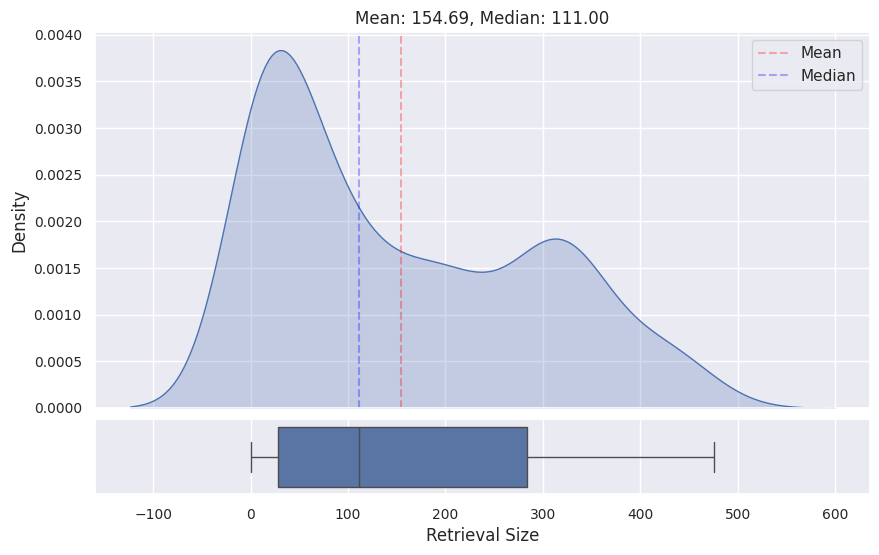

In [242]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

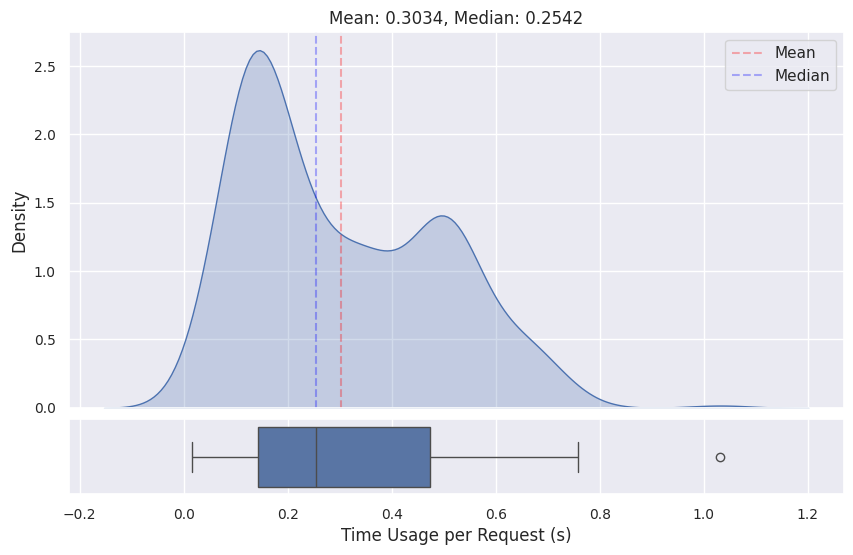

In [74]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

### Recall

In [244]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9757869249394673

### Accuracy

In [245]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8354
Top 2 accuracy: 0.8910
Top 3 accuracy: 0.9104
Top 4 accuracy: 0.9177
Top 5 accuracy: 0.9322
Top 6 accuracy: 0.9395
Top 7 accuracy: 0.9467
Top 8 accuracy: 0.9492
Top 9 accuracy: 0.9540
Top 10 accuracy: 0.9564
Top 11 accuracy: 0.9564
Top 12 accuracy: 0.9588
Top 13 accuracy: 0.9613
Top 14 accuracy: 0.9637
Top 15 accuracy: 0.9637
Top 16 accuracy: 0.9685
Top 17 accuracy: 0.9685
Top 18 accuracy: 0.9685
Top 19 accuracy: 0.9685
Top 20 accuracy: 0.9685


# Context Search

In [24]:
keywords_search = False
case_number = False
law_number = False
context_search = True

for k in range(5, 101, 5):
    print(f'k = {k}')
    results = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        start = time.time()
        retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                        idf=True, case_number=case_number, law_number=law_number,
                                        context_search=context_search, k=k)
        sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
        sources = [source for source in sources if 'law' not in source]
        if sources:
            scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
            sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
            sorted_scores, sorted_sources = zip(*sorted_pairs)
            sorted_scores = list(sorted_scores)
            sorted_sources = list(sorted_sources)
        else:
            sorted_sources = []
            sorted_scores = []
        results.append({
            'question': row['question'],
            'source': row['source'],
            'retrieved_sources': sorted_sources,
            'reranking_scores': sorted_scores,
            'time': time.time() - start
        })
    with open(f'retrieval_result/context_search_k={k}.json', 'w') as file:
        json.dump(results, file, indent=4, ensure_ascii=False)

k = 5


100%|██████████| 413/413 [00:34<00:00, 11.87it/s]


k = 10


100%|██████████| 413/413 [00:45<00:00,  9.10it/s]


k = 15


100%|██████████| 413/413 [00:47<00:00,  8.68it/s]


k = 20


100%|██████████| 413/413 [00:48<00:00,  8.54it/s]


k = 25


100%|██████████| 413/413 [00:49<00:00,  8.39it/s]


k = 30


100%|██████████| 413/413 [00:50<00:00,  8.14it/s]


k = 35


100%|██████████| 413/413 [00:51<00:00,  8.01it/s]


k = 40


100%|██████████| 413/413 [00:52<00:00,  7.88it/s]


k = 45


100%|██████████| 413/413 [00:54<00:00,  7.56it/s]


k = 50


100%|██████████| 413/413 [00:55<00:00,  7.40it/s]


k = 55


100%|██████████| 413/413 [00:58<00:00,  7.11it/s]


k = 60


100%|██████████| 413/413 [01:00<00:00,  6.87it/s]


k = 65


100%|██████████| 413/413 [01:03<00:00,  6.52it/s]


k = 70


100%|██████████| 413/413 [01:05<00:00,  6.32it/s]


k = 75


100%|██████████| 413/413 [01:07<00:00,  6.14it/s]


k = 80


100%|██████████| 413/413 [01:09<00:00,  5.94it/s]


k = 85


100%|██████████| 413/413 [01:12<00:00,  5.72it/s]


k = 90


100%|██████████| 413/413 [01:14<00:00,  5.55it/s]


k = 95


100%|██████████| 413/413 [01:17<00:00,  5.36it/s]


k = 100


100%|██████████| 413/413 [01:18<00:00,  5.24it/s]


In [197]:
ks = list(range(5, 101, 5))

In [198]:
context_results_dict = {}
for k in ks:
    with open(f'retrieval_result/context_search_k={k}.json') as file:
        context_results_dict[k] = json.load(file)

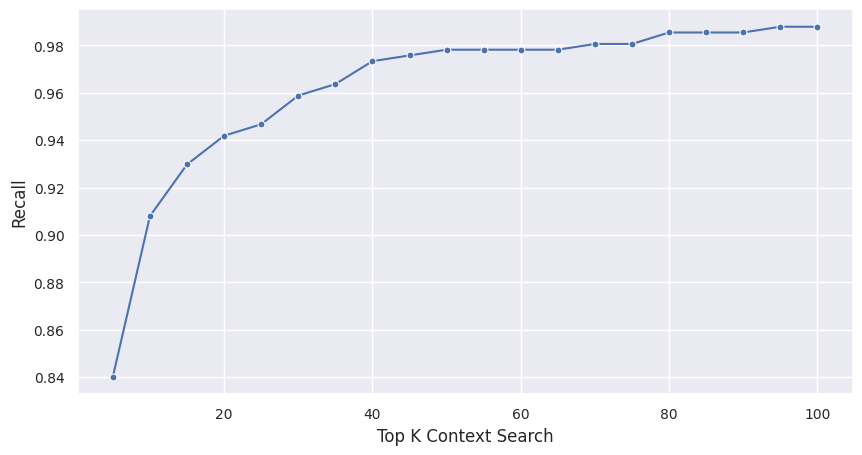

In [199]:
recalls = []
for k in context_results_dict:
    results = context_results_dict[k]
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'])
    recalls.append((sum(hits) / len(hits)))

plt.figure(figsize=(10, 5))

sns.lineplot(x=ks, y=recalls, marker='o', markersize=5)
plt.xlabel('Top K Context Search')
plt.ylabel('Recall')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

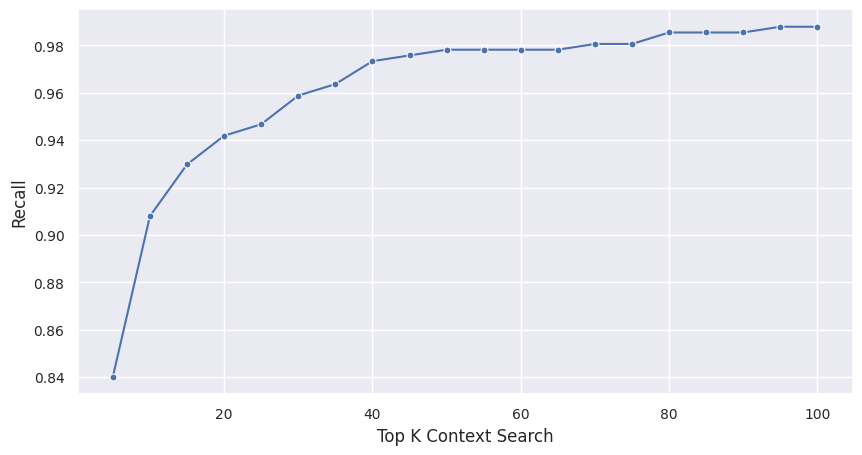

In [204]:
recalls = []
for k in context_results_dict:
    results = context_results_dict[k]
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'])
    recalls.append((sum(hits) / len(hits)))

plt.figure(figsize=(10, 5))

sns.lineplot(x=ks, y=recalls, marker='o', markersize=5)
plt.xlabel('Top K Context Search')
plt.ylabel('Recall')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

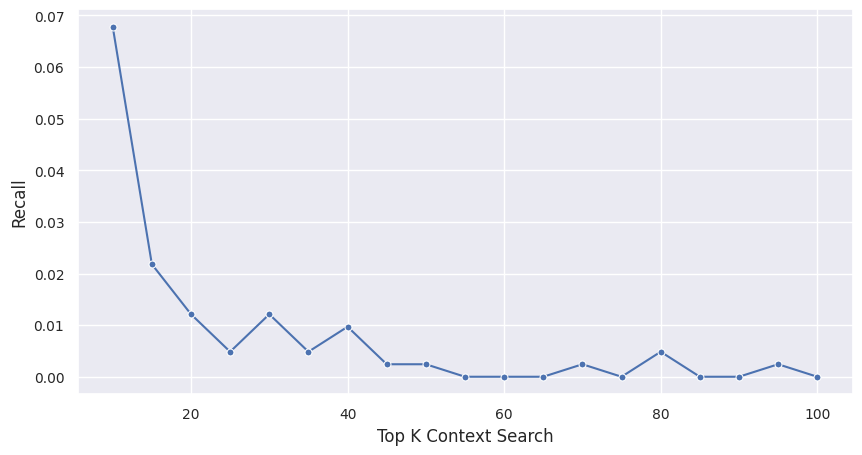

In [205]:
increasing_rates = [None]
for i in range(1, len(recalls)):
    increasing_rates.append(recalls[i] - recalls[i-1])

plt.figure(figsize=(10, 5))

sns.lineplot(x=ks, y=increasing_rates, marker='o', markersize=5)
plt.xlabel('Top K Context Search')
plt.ylabel('Recall')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

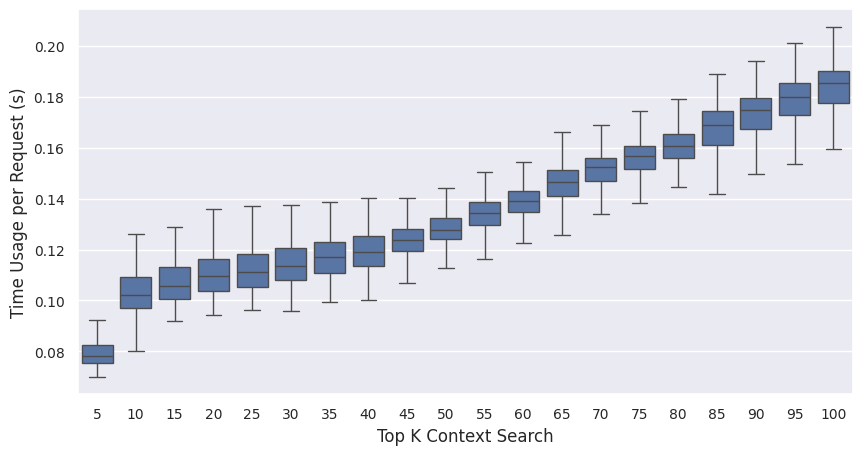

In [105]:
time_df = {
    'k': [],
    'time': []
}
for k in context_results_dict:
    results = context_results_dict[k]
    time_df['k'] += [k] * len(results)
    time_df['time'] += [result['time'] for result in results]
time_df = pd.DataFrame(time_df)

plt.figure(figsize=(10, 5))
sns.boxplot(data=time_df, x='k', y='time', showfliers=False)
plt.xlabel('Top K Context Search')
plt.ylabel('Time Usage per Request (s)')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

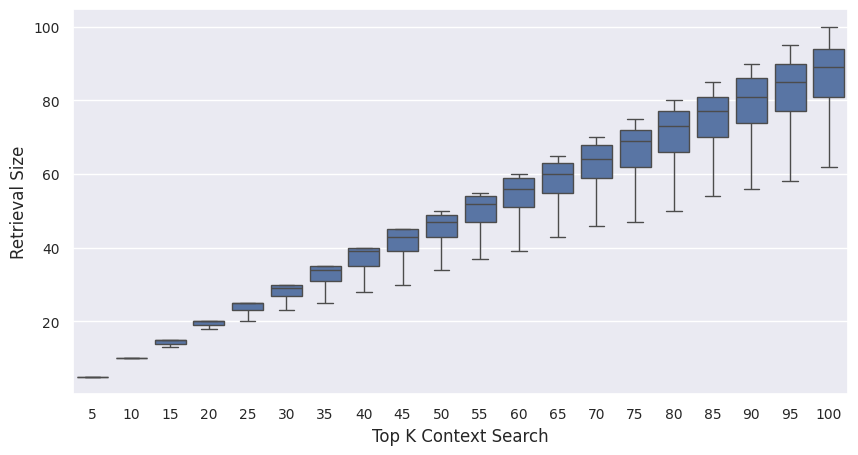

In [106]:
size_df = {
    'k': [],
    'size': []
}
for k in context_results_dict:
    results = context_results_dict[k]
    size_df['k'] += [k] * len(results)
    size_df['size'] += [len(result['retrieved_sources']) for result in results]
size_df = pd.DataFrame(size_df)

plt.figure(figsize=(10, 5))
sns.boxplot(data=size_df, x='k', y='size', showfliers=False)
plt.xlabel('Top K Context Search')
plt.ylabel('Retrieval Size')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

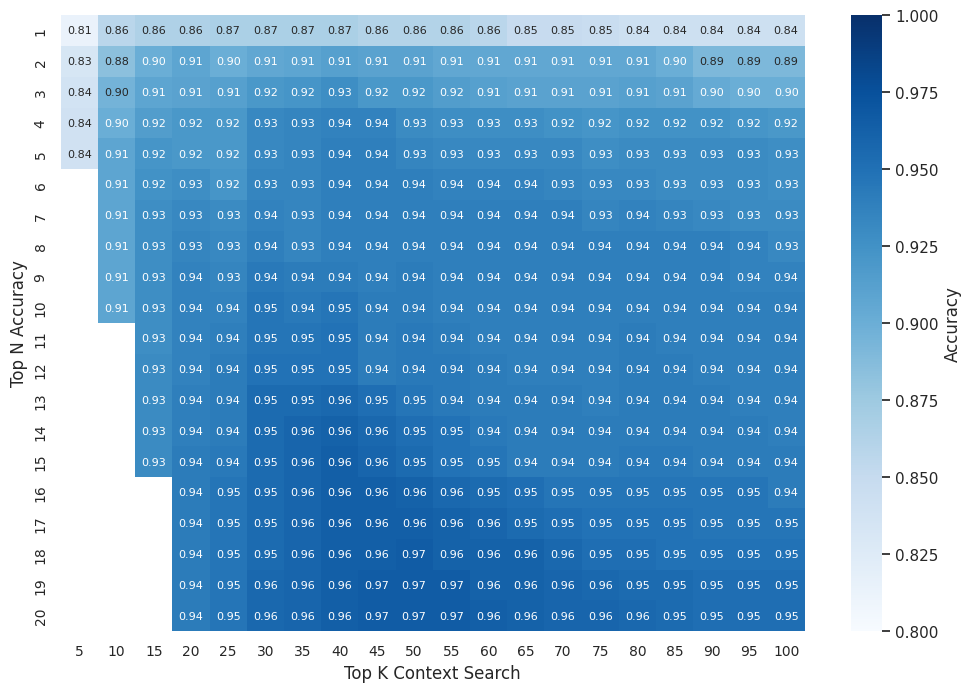

In [107]:
accuracy_df = []
for k in context_results_dict:
    results = context_results_dict[k]
    top_n_accuracy = {
        'k': k
    }
    for n in range(1, 21):
        if n > k:
            break
        hits = []
        for result in results:
            hits.append(result['source'] in result['retrieved_sources'][:n])
        top_n_accuracy[n] = sum(hits) / len(hits)
    accuracy_df.append(top_n_accuracy)
accuracy_df = pd.DataFrame(accuracy_df)

sns.set_style('white')
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_df.set_index('k').T, cmap='Blues', vmin=0.8, vmax=1, annot=True,
            cbar_kws={'label': 'Accuracy'}, annot_kws={'size': 8}, fmt='.2f')
plt.xlabel('Top K Context Search')
plt.ylabel('Top N Accuracy')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
sns.set_theme()

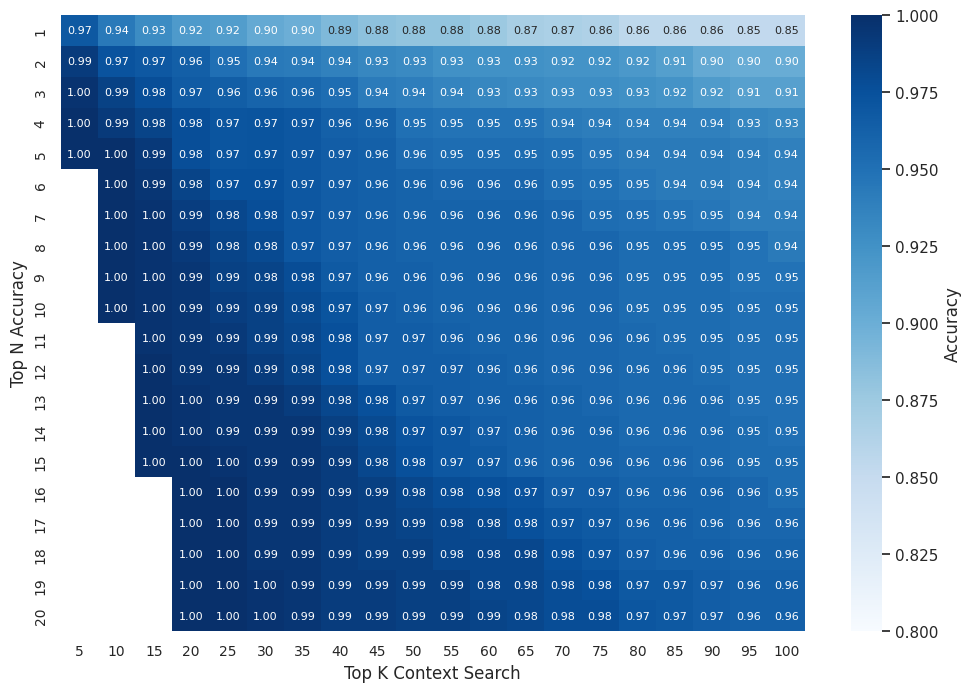

In [108]:
accuracy_df = []
for k in context_results_dict:
    results = context_results_dict[k]
    top_n_accuracy = {
        'k': k
    }
    for n in range(1, 21):
        if n > k:
            break
        hits = []
        for result in results:
            if result['source'] in result['retrieved_sources']:
                hits.append(result['source'] in result['retrieved_sources'][:n])
        top_n_accuracy[n] = sum(hits) / len(hits)
    accuracy_df.append(top_n_accuracy)
accuracy_df = pd.DataFrame(accuracy_df)

sns.set_style('white')
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_df.set_index('k').T, cmap='Blues', vmin=0.8, vmax=1, annot=True,
            cbar_kws={'label': 'Accuracy'}, annot_kws={'size': 8}, fmt='.2f')
plt.xlabel('Top K Context Search')
plt.ylabel('Top N Accuracy')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
sns.set_theme()

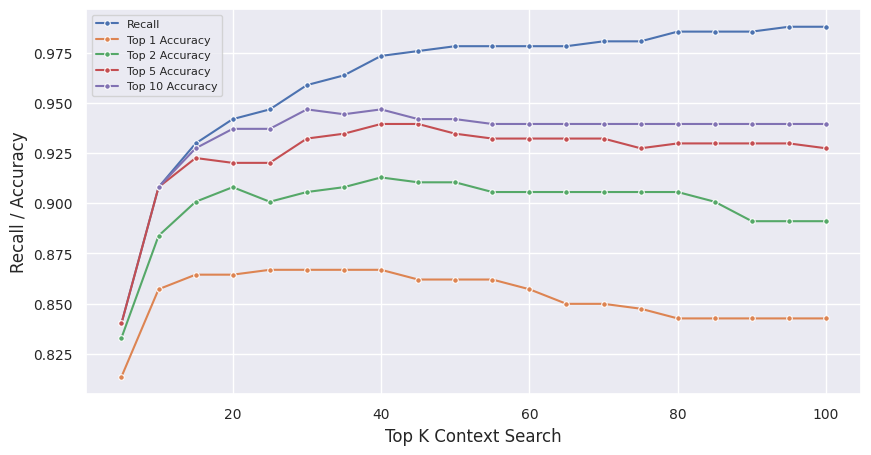

In [137]:
recalls = []
for k in context_results_dict:
    results = context_results_dict[k]
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'])
    recalls.append((sum(hits) / len(hits)))

accuracy_df = []
for k in context_results_dict:
    results = context_results_dict[k]
    top_n_accuracy = {
        'k': k
    }
    for n in [1, 2, 5, 10]:
        if n > k:
            break
        hits = []
        for result in results:
            hits.append(result['source'] in result['retrieved_sources'][:n])
        top_n_accuracy[n] = sum(hits) / len(hits)
    accuracy_df.append(top_n_accuracy)
accuracy_df = pd.DataFrame(accuracy_df)

plt.figure(figsize=(10, 5))

sns.lineplot(x=accuracy_df['k'], y=recalls, marker='o', markersize=4, label='Recall')
for n in [1, 2, 5, 10]:
    sns.lineplot(data=accuracy_df, x='k', y=n, marker='o', markersize=4, label=f'Top {n} Accuracy')
plt.xlabel('Top K Context Search')
plt.ylabel('Recall / Accuracy')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.show()

## k = 10

In [138]:
k = 10
results = context_results_dict[k]

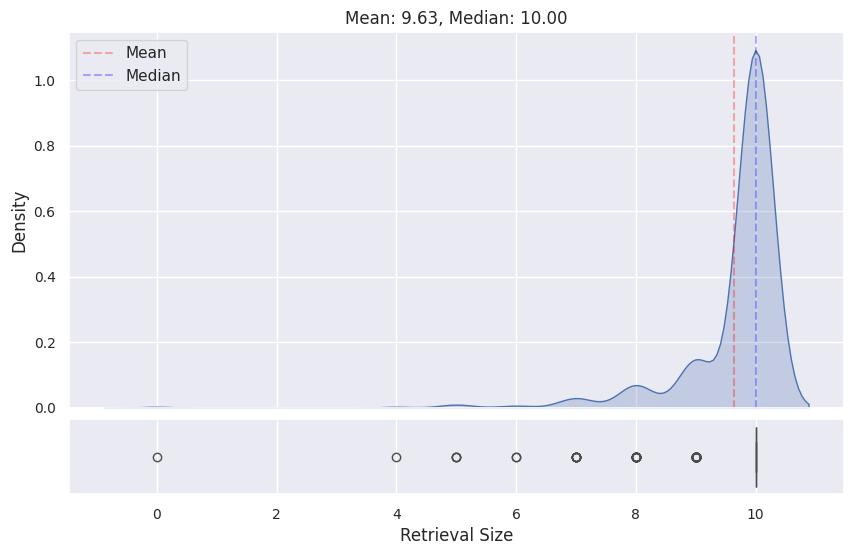

In [143]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2, showfliers=True)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

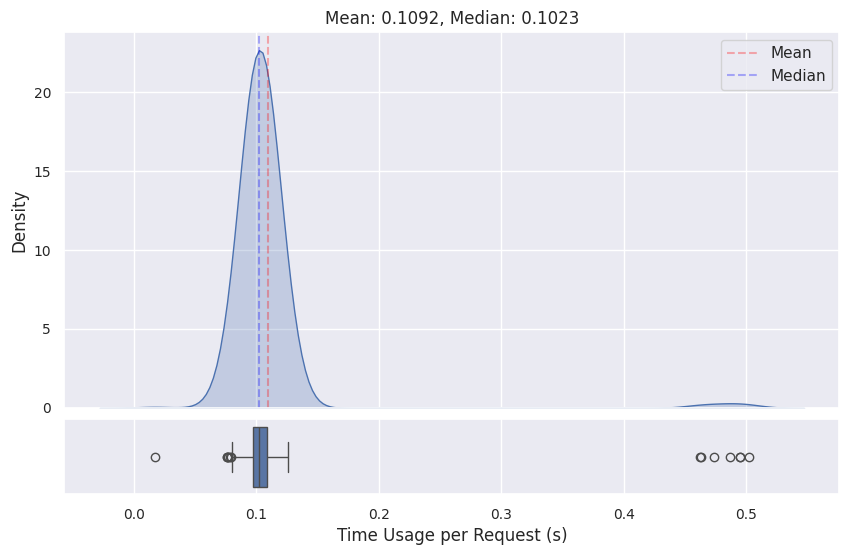

In [142]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2, showfliers=True)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [144]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9079903147699758

In [145]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8571
Top 2 accuracy: 0.8838
Top 3 accuracy: 0.8959
Top 4 accuracy: 0.9007
Top 5 accuracy: 0.9080
Top 6 accuracy: 0.9080
Top 7 accuracy: 0.9080
Top 8 accuracy: 0.9080
Top 9 accuracy: 0.9080
Top 10 accuracy: 0.9080
Top 11 accuracy: 0.9080
Top 12 accuracy: 0.9080
Top 13 accuracy: 0.9080
Top 14 accuracy: 0.9080
Top 15 accuracy: 0.9080
Top 16 accuracy: 0.9080
Top 17 accuracy: 0.9080
Top 18 accuracy: 0.9080
Top 19 accuracy: 0.9080
Top 20 accuracy: 0.9080


In [146]:
for n in range(1, 21):
    hits = []
    for result in results:
        if result['source'] in result['retrieved_sources']:
            hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.9440
Top 2 accuracy: 0.9733
Top 3 accuracy: 0.9867
Top 4 accuracy: 0.9920
Top 5 accuracy: 1.0000
Top 6 accuracy: 1.0000
Top 7 accuracy: 1.0000
Top 8 accuracy: 1.0000
Top 9 accuracy: 1.0000
Top 10 accuracy: 1.0000
Top 11 accuracy: 1.0000
Top 12 accuracy: 1.0000
Top 13 accuracy: 1.0000
Top 14 accuracy: 1.0000
Top 15 accuracy: 1.0000
Top 16 accuracy: 1.0000
Top 17 accuracy: 1.0000
Top 18 accuracy: 1.0000
Top 19 accuracy: 1.0000
Top 20 accuracy: 1.0000


## k = 20

In [148]:
k = 20
results = context_results_dict[k]

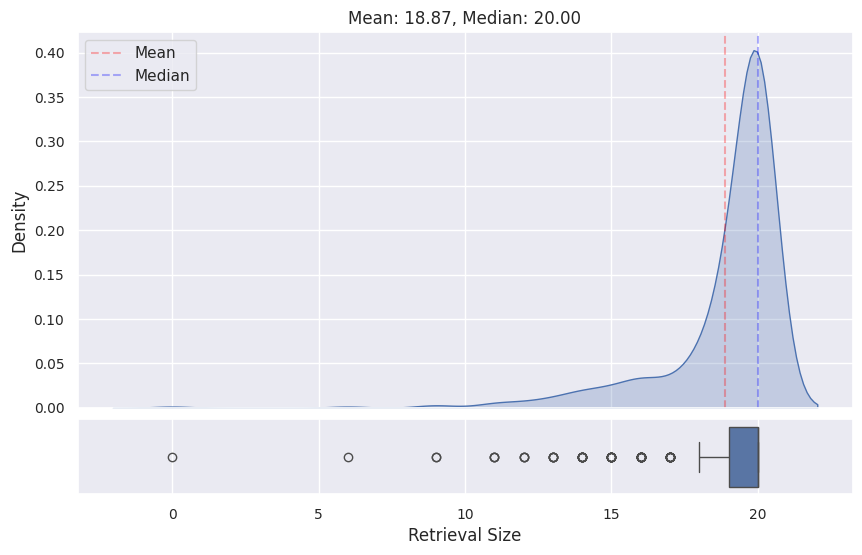

In [149]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2, showfliers=True)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

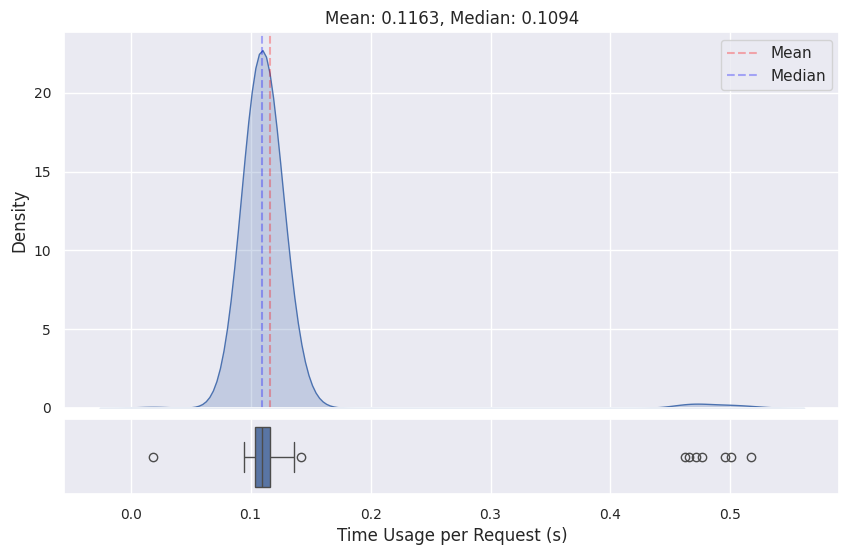

In [150]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2, showfliers=True)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [151]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9418886198547215

In [152]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8644
Top 2 accuracy: 0.9080
Top 3 accuracy: 0.9104
Top 4 accuracy: 0.9201
Top 5 accuracy: 0.9201
Top 6 accuracy: 0.9274
Top 7 accuracy: 0.9322
Top 8 accuracy: 0.9346
Top 9 accuracy: 0.9370
Top 10 accuracy: 0.9370
Top 11 accuracy: 0.9370
Top 12 accuracy: 0.9370
Top 13 accuracy: 0.9395
Top 14 accuracy: 0.9395
Top 15 accuracy: 0.9419
Top 16 accuracy: 0.9419
Top 17 accuracy: 0.9419
Top 18 accuracy: 0.9419
Top 19 accuracy: 0.9419
Top 20 accuracy: 0.9419


In [153]:
for n in range(1, 21):
    hits = []
    for result in results:
        if result['source'] in result['retrieved_sources']:
            hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.9177
Top 2 accuracy: 0.9640
Top 3 accuracy: 0.9666
Top 4 accuracy: 0.9769
Top 5 accuracy: 0.9769
Top 6 accuracy: 0.9846
Top 7 accuracy: 0.9897
Top 8 accuracy: 0.9923
Top 9 accuracy: 0.9949
Top 10 accuracy: 0.9949
Top 11 accuracy: 0.9949
Top 12 accuracy: 0.9949
Top 13 accuracy: 0.9974
Top 14 accuracy: 0.9974
Top 15 accuracy: 1.0000
Top 16 accuracy: 1.0000
Top 17 accuracy: 1.0000
Top 18 accuracy: 1.0000
Top 19 accuracy: 1.0000
Top 20 accuracy: 1.0000


## k = 30

In [154]:
k = 30
results = context_results_dict[k]

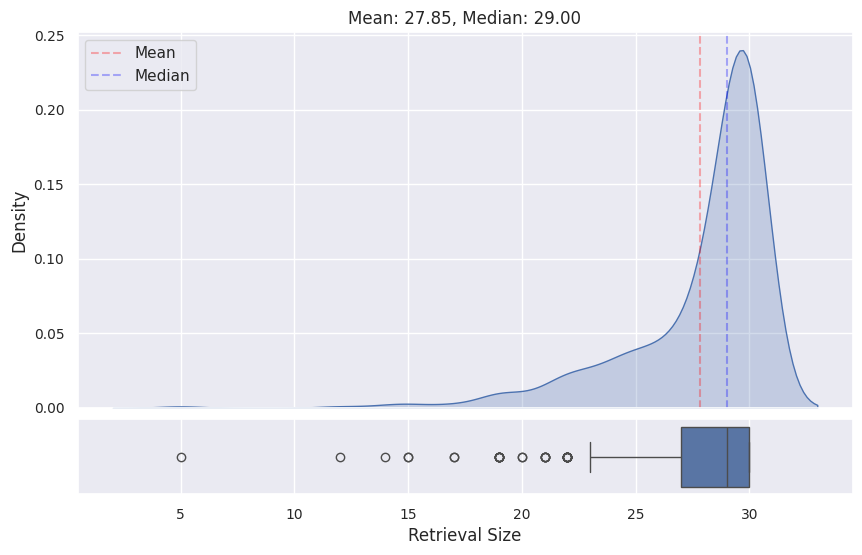

In [155]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2, showfliers=True)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

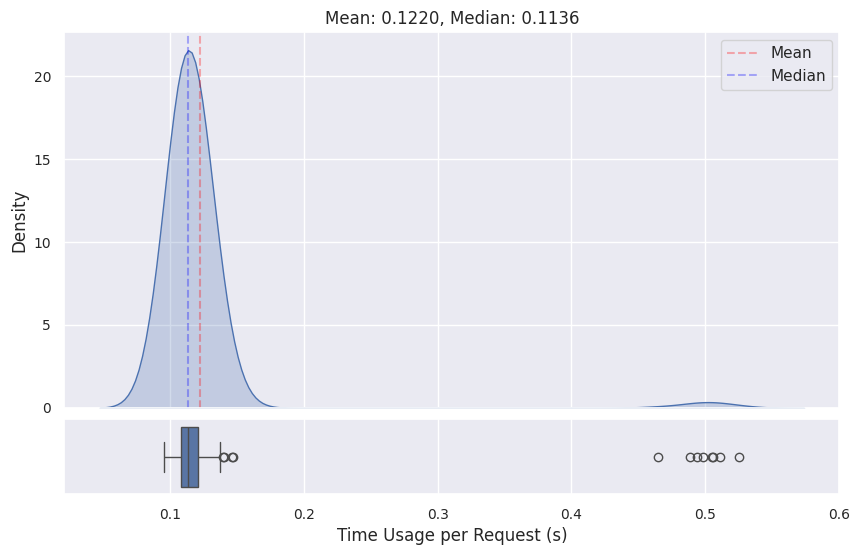

In [156]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2, showfliers=True)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [157]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9588377723970944

In [158]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8668
Top 2 accuracy: 0.9056
Top 3 accuracy: 0.9201
Top 4 accuracy: 0.9322
Top 5 accuracy: 0.9322
Top 6 accuracy: 0.9346
Top 7 accuracy: 0.9370
Top 8 accuracy: 0.9395
Top 9 accuracy: 0.9443
Top 10 accuracy: 0.9467
Top 11 accuracy: 0.9467
Top 12 accuracy: 0.9492
Top 13 accuracy: 0.9540
Top 14 accuracy: 0.9540
Top 15 accuracy: 0.9540
Top 16 accuracy: 0.9540
Top 17 accuracy: 0.9540
Top 18 accuracy: 0.9540
Top 19 accuracy: 0.9564
Top 20 accuracy: 0.9564


In [159]:
for n in range(1, 21):
    hits = []
    for result in results:
        if result['source'] in result['retrieved_sources']:
            hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.9040
Top 2 accuracy: 0.9444
Top 3 accuracy: 0.9596
Top 4 accuracy: 0.9722
Top 5 accuracy: 0.9722
Top 6 accuracy: 0.9747
Top 7 accuracy: 0.9773
Top 8 accuracy: 0.9798
Top 9 accuracy: 0.9848
Top 10 accuracy: 0.9874
Top 11 accuracy: 0.9874
Top 12 accuracy: 0.9899
Top 13 accuracy: 0.9949
Top 14 accuracy: 0.9949
Top 15 accuracy: 0.9949
Top 16 accuracy: 0.9949
Top 17 accuracy: 0.9949
Top 18 accuracy: 0.9949
Top 19 accuracy: 0.9975
Top 20 accuracy: 0.9975


## k = 40

In [160]:
k = 40
results = context_results_dict[k]

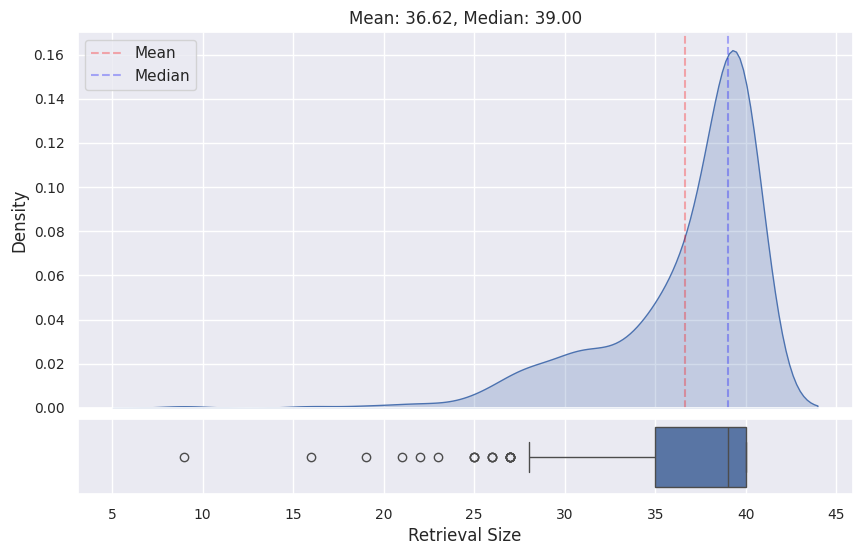

In [161]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2, showfliers=True)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

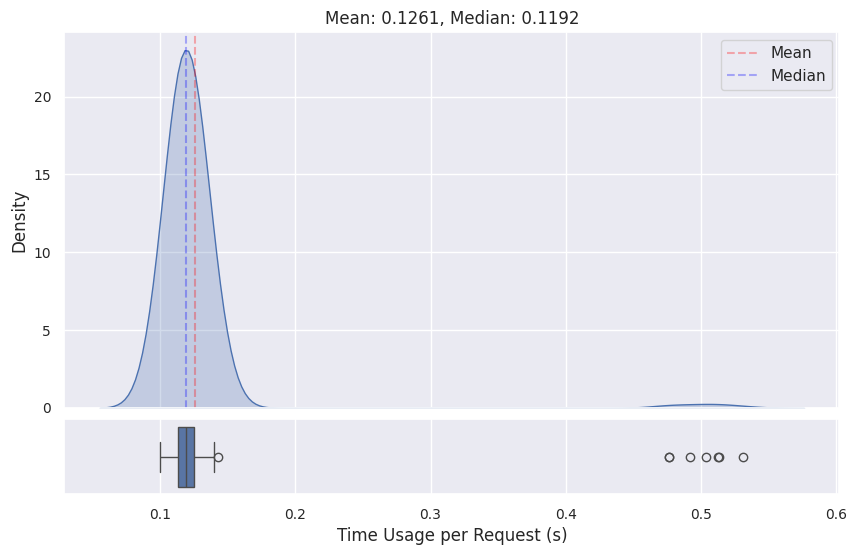

In [162]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2, showfliers=True)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [163]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9733656174334141

In [164]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8668
Top 2 accuracy: 0.9128
Top 3 accuracy: 0.9274
Top 4 accuracy: 0.9370
Top 5 accuracy: 0.9395
Top 6 accuracy: 0.9395
Top 7 accuracy: 0.9395
Top 8 accuracy: 0.9395
Top 9 accuracy: 0.9419
Top 10 accuracy: 0.9467
Top 11 accuracy: 0.9492
Top 12 accuracy: 0.9492
Top 13 accuracy: 0.9564
Top 14 accuracy: 0.9613
Top 15 accuracy: 0.9637
Top 16 accuracy: 0.9637
Top 17 accuracy: 0.9637
Top 18 accuracy: 0.9637
Top 19 accuracy: 0.9637
Top 20 accuracy: 0.9637


In [165]:
for n in range(1, 21):
    hits = []
    for result in results:
        if result['source'] in result['retrieved_sources']:
            hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8905
Top 2 accuracy: 0.9378
Top 3 accuracy: 0.9527
Top 4 accuracy: 0.9627
Top 5 accuracy: 0.9652
Top 6 accuracy: 0.9652
Top 7 accuracy: 0.9652
Top 8 accuracy: 0.9652
Top 9 accuracy: 0.9677
Top 10 accuracy: 0.9726
Top 11 accuracy: 0.9751
Top 12 accuracy: 0.9751
Top 13 accuracy: 0.9826
Top 14 accuracy: 0.9876
Top 15 accuracy: 0.9900
Top 16 accuracy: 0.9900
Top 17 accuracy: 0.9900
Top 18 accuracy: 0.9900
Top 19 accuracy: 0.9900
Top 20 accuracy: 0.9900


# Keyword + Context Search

In [246]:
keywords_search = True
case_number = False
law_number = True
context_search = True

for k in range(10, 51, 10):
    print(f'k = {k}')
    results = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        start = time.time()
        retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                        idf=True, case_number=case_number, law_number=law_number,
                                        context_search=context_search, k=k)
        sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
        sources = [source for source in sources if 'law' not in source]
        if sources:
            scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
            sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
            sorted_scores, sorted_sources = zip(*sorted_pairs)
            sorted_scores = list(sorted_scores)
            sorted_sources = list(sorted_sources)
        else:
            sorted_sources = []
            sorted_scores = []
        results.append({
            'question': row['question'],
            'source': row['source'],
            'retrieved_sources': sorted_sources,
            'reranking_scores': sorted_scores,
            'time': time.time() - start
        })
    with open(f'retrieval_result/_law_number_context_search_k={k}.json', 'w') as file:
        json.dump(results, file, indent=4, ensure_ascii=False)

k = 10


100%|██████████| 413/413 [05:32<00:00,  1.24it/s]


k = 20


100%|██████████| 413/413 [05:31<00:00,  1.25it/s]


k = 30


100%|██████████| 413/413 [05:35<00:00,  1.23it/s]


k = 40


100%|██████████| 413/413 [05:41<00:00,  1.21it/s]


k = 50


100%|██████████| 413/413 [05:49<00:00,  1.18it/s]


In [14]:
ks = list(range(10, 51, 10))

In [15]:
law_number_context_results_dict = {}
for k in ks:
    with open(f'retrieval_result/_law_number_context_search_k={k}.json') as file:
        law_number_context_results_dict[k] = json.load(file)

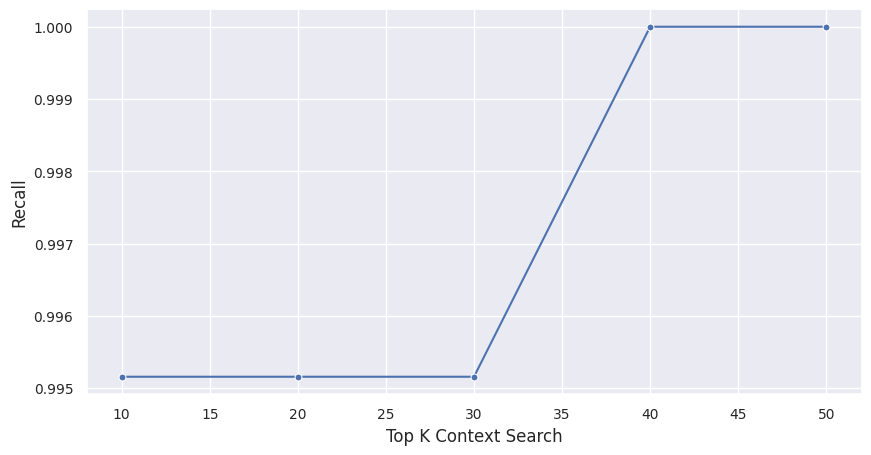

In [255]:
recalls = []
for k in law_number_context_results_dict:
    results = law_number_context_results_dict[k]
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'])
    recalls.append((sum(hits) / len(hits)))

plt.figure(figsize=(10, 5))

sns.lineplot(x=ks, y=recalls, marker='o', markersize=5)
plt.xlabel('Top K Context Search')
plt.ylabel('Recall')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

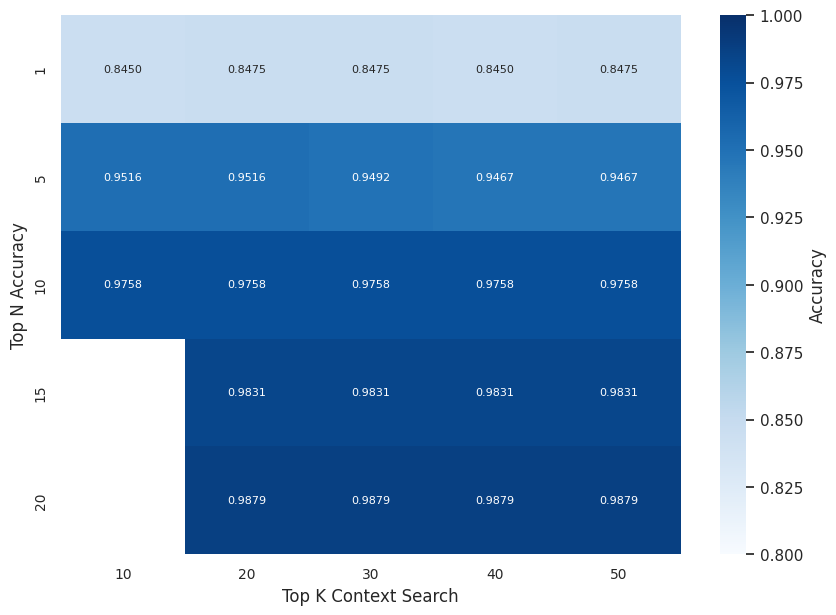

In [256]:
accuracy_df = []
for k in law_number_context_results_dict:
    results = law_number_context_results_dict[k]
    top_n_accuracy = {
        'k': k
    }
    for n in [1, 5, 10, 15, 20]:
        if n > k:
            break
        hits = []
        for result in results:
            hits.append(result['source'] in result['retrieved_sources'][:n])
        top_n_accuracy[n] = sum(hits) / len(hits)
    accuracy_df.append(top_n_accuracy)
accuracy_df = pd.DataFrame(accuracy_df)

sns.set_style('white')
plt.figure(figsize=(10, 7))
sns.heatmap(accuracy_df.set_index('k').T, cmap='Blues', vmin=0.8, vmax=1, annot=True,
            cbar_kws={'label': 'Accuracy'}, annot_kws={'size': 8}, fmt='.4f')
plt.xlabel('Top K Context Search')
plt.ylabel('Top N Accuracy')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
sns.set_theme()

## Law Number + k = 40

In [257]:
k = 40
results = law_number_context_results_dict[k]

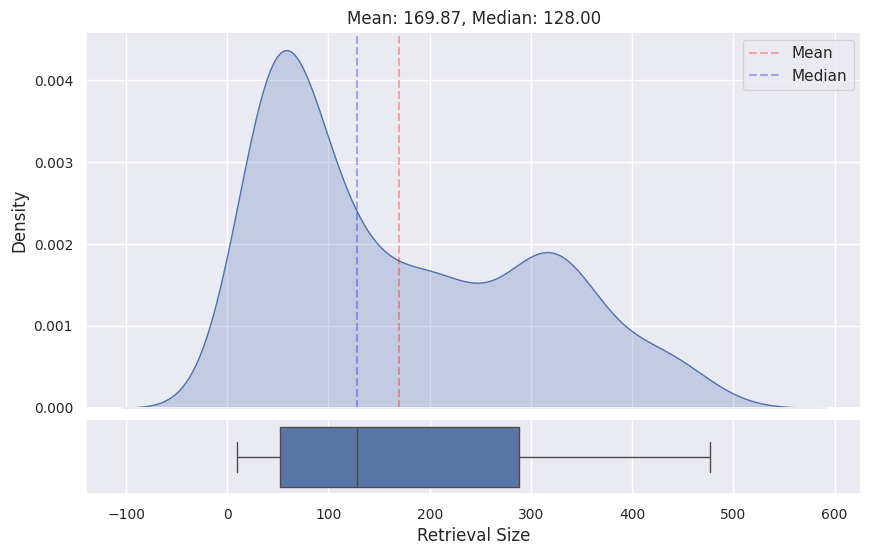

In [258]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(retrieved_sizes, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.2f}, Median: {median:.2f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=retrieved_sizes, ax=ax2, showfliers=True)
ax2.set_xlabel('Retrieval Size')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

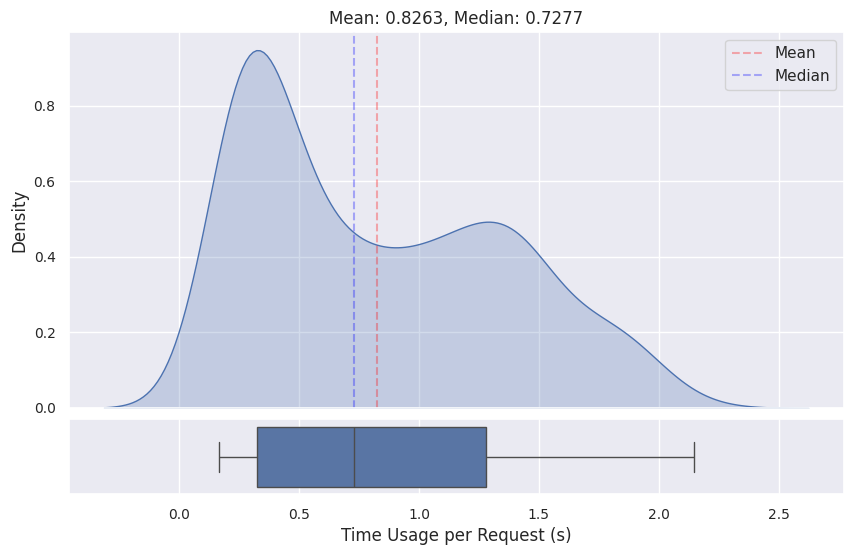

In [259]:
times = [result['time'] for result in results]
mean = np.mean(times)
median = np.median(times)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]})

sns.kdeplot(times, ax=ax1, fill=True)
ax1.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
ax1.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
ax1.set_title(f'Mean: {mean:.4f}, Median: {median:.4f}')
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend()

sns.boxplot(x=times, ax=ax2, showfliers=True)
ax2.set_xlabel('Time Usage per Request (s)')
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [260]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

1.0

In [261]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8450
Top 2 accuracy: 0.9031
Top 3 accuracy: 0.9225
Top 4 accuracy: 0.9322
Top 5 accuracy: 0.9467
Top 6 accuracy: 0.9564
Top 7 accuracy: 0.9661
Top 8 accuracy: 0.9685
Top 9 accuracy: 0.9734
Top 10 accuracy: 0.9758
Top 11 accuracy: 0.9758
Top 12 accuracy: 0.9782
Top 13 accuracy: 0.9806
Top 14 accuracy: 0.9831
Top 15 accuracy: 0.9831
Top 16 accuracy: 0.9831
Top 17 accuracy: 0.9855
Top 18 accuracy: 0.9855
Top 19 accuracy: 0.9879
Top 20 accuracy: 0.9879


In [363]:
keywords_search = False
case_number = False
law_number = False
context_search = True
k = 20

In [312]:
results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                    idf=True, case_number=case_number, law_number=law_number,
                                    context_search=context_search, k=k)
    sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
    sources = [source for source in sources if 'law' not in source]
    if sources:
        scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
        sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
        sorted_scores, sorted_sources = zip(*sorted_pairs)
        sorted_scores = list(sorted_scores)
        sorted_sources = list(sorted_sources)
    else:
        sorted_sources = []
        sorted_scores = []
    results.append({
        'question': row['question'],
        'source': row['source'],
        'retrieved_sources': sorted_sources,
        'reranking_scores': sorted_scores
    })

100%|██████████| 413/413 [00:47<00:00,  8.73it/s]


In [313]:
with open(f'retrieval_result/context_search_k={k}.json', 'w') as file:
    json.dump(results, file, indent=4, ensure_ascii=False)

In [364]:
with open(f'retrieval_result/context_search_k={k}.json') as file:
    results = json.load(file)

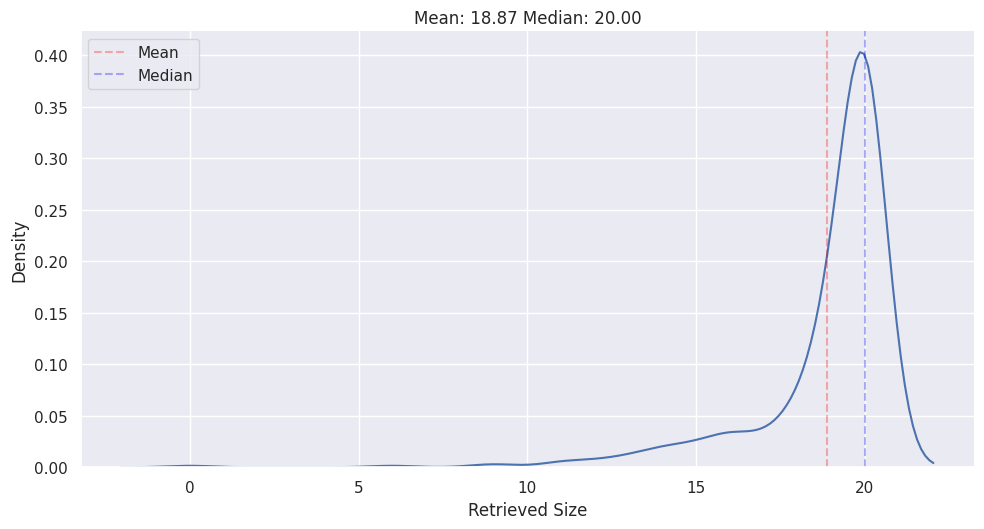

In [365]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

sns.displot(retrieved_sizes, kind='kde', height=5, aspect=2)
plt.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
plt.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
plt.title(f'Mean: {mean:.02f} Median: {median:.02f}')
plt.xlabel('Retrieved Size')
plt.legend()
plt.show()

In [317]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9418886198547215

In [318]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8644
Top 2 accuracy: 0.9080
Top 3 accuracy: 0.9104
Top 4 accuracy: 0.9201
Top 5 accuracy: 0.9201
Top 6 accuracy: 0.9274
Top 7 accuracy: 0.9322
Top 8 accuracy: 0.9346
Top 9 accuracy: 0.9370
Top 10 accuracy: 0.9370
Top 11 accuracy: 0.9370
Top 12 accuracy: 0.9370
Top 13 accuracy: 0.9395
Top 14 accuracy: 0.9395
Top 15 accuracy: 0.9419
Top 16 accuracy: 0.9419
Top 17 accuracy: 0.9419
Top 18 accuracy: 0.9419
Top 19 accuracy: 0.9419
Top 20 accuracy: 0.9419


In [366]:
keywords_search = False
case_number = False
law_number = False
context_search = True
k = 30

In [367]:
results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                    idf=True, case_number=case_number, law_number=law_number,
                                    context_search=context_search, k=k)
    sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
    sources = [source for source in sources if 'law' not in source]
    if sources:
        scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
        sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
        sorted_scores, sorted_sources = zip(*sorted_pairs)
        sorted_scores = list(sorted_scores)
        sorted_sources = list(sorted_sources)
    else:
        sorted_sources = []
        sorted_scores = []
    results.append({
        'question': row['question'],
        'source': row['source'],
        'retrieved_sources': sorted_sources,
        'reranking_scores': sorted_scores
    })

100%|██████████| 413/413 [00:52<00:00,  7.80it/s]


In [368]:
with open(f'retrieval_result/context_search_k={k}.json', 'w') as file:
    json.dump(results, file, indent=4, ensure_ascii=False)

In [369]:
with open(f'retrieval_result/context_search_k={k}.json') as file:
    results = json.load(file)

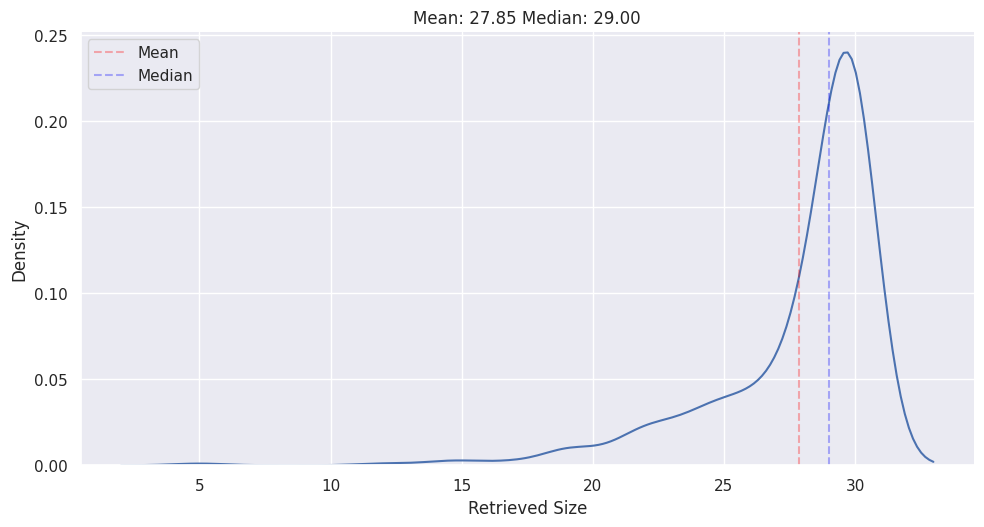

In [370]:
retrieved_sizes = [len(result['retrieved_sources']) for result in results]
mean = np.mean(retrieved_sizes)
median = np.median(retrieved_sizes)

sns.displot(retrieved_sizes, kind='kde', height=5, aspect=2)
plt.axvline(x=mean, color='red', linestyle='--', alpha=0.3, label='Mean')
plt.axvline(x=median, color='blue', linestyle='--', alpha=0.3, label='Median')
plt.title(f'Mean: {mean:.02f} Median: {median:.02f}')
plt.xlabel('Retrieved Size')
plt.legend()
plt.show()

In [371]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

0.9588377723970944

In [372]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.8668
Top 2 accuracy: 0.9056
Top 3 accuracy: 0.9201
Top 4 accuracy: 0.9322
Top 5 accuracy: 0.9322
Top 6 accuracy: 0.9346
Top 7 accuracy: 0.9370
Top 8 accuracy: 0.9395
Top 9 accuracy: 0.9443
Top 10 accuracy: 0.9467
Top 11 accuracy: 0.9467
Top 12 accuracy: 0.9492
Top 13 accuracy: 0.9540
Top 14 accuracy: 0.9540
Top 15 accuracy: 0.9540
Top 16 accuracy: 0.9540
Top 17 accuracy: 0.9540
Top 18 accuracy: 0.9540
Top 19 accuracy: 0.9564
Top 20 accuracy: 0.9564


# Reranker (Similar + Keyword)

In [17]:
reranker = FlagReranker('/project/lt200301-edubot/Capstone-TamTanai/models/bge-reranker-v2-m3-finetune-with_similar=5_keyword=5', use_fp16=True)

----------using 4*GPUs----------


In [18]:
k = 40
results = law_number_context_results_dict[k]

In [22]:
keywords_search = True
case_number = False
law_number = True
context_search = True

k = 40
print(f'k = {k}')
results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    start = time.time()
    retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                    idf=True, case_number=case_number, law_number=law_number,
                                    context_search=context_search, k=k)
    sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
    sources = [source for source in sources if 'law' not in source]
    if sources:
        scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
        sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
        sorted_scores, sorted_sources = zip(*sorted_pairs)
        sorted_scores = list(sorted_scores)
        sorted_sources = list(sorted_sources)
    else:
        sorted_sources = []
        sorted_scores = []
    results.append({
        'question': row['question'],
        'source': row['source'],
        'retrieved_sources': sorted_sources,
        'reranking_scores': sorted_scores,
        'time': time.time() - start
    })
with open(f'retrieval_result/law_number_context_search_k={k}_raranker_similar=5_keyword=5.json', 'w') as file:
    json.dump(results, file, indent=4, ensure_ascii=False)

k = 40


100%|██████████| 413/413 [02:19<00:00,  2.95it/s]


In [23]:
k = 40
with open(f'retrieval_result/law_number_context_search_k={k}_raranker_similar=5_keyword=5.json') as file:
    results = json.load(file)

In [25]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

1.0

In [24]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.9395
Top 2 accuracy: 0.9758
Top 3 accuracy: 0.9831
Top 4 accuracy: 0.9831
Top 5 accuracy: 0.9831
Top 6 accuracy: 0.9879
Top 7 accuracy: 0.9879
Top 8 accuracy: 0.9903
Top 9 accuracy: 0.9927
Top 10 accuracy: 0.9927
Top 11 accuracy: 0.9976
Top 12 accuracy: 0.9976
Top 13 accuracy: 0.9976
Top 14 accuracy: 0.9976
Top 15 accuracy: 0.9976
Top 16 accuracy: 1.0000
Top 17 accuracy: 1.0000
Top 18 accuracy: 1.0000
Top 19 accuracy: 1.0000
Top 20 accuracy: 1.0000


## Reranking result

In [16]:
reranker = FlagReranker('/project/lt200301-edubot/Capstone-TamTanai/models/bge-reranker-v2-m3-finetune-with_similar=5_keyword=5_2nd', use_fp16=True)

----------using 4*GPUs----------


In [17]:
keywords_search = True
case_number = False
law_number = True
context_search = True

k = 40
print(f'k = {k}')
results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    start = time.time()
    retrieved_documents = retriever(row['question'], documents, vectordb, keywords_search=keywords_search,
                                    idf=True, case_number=case_number, law_number=law_number,
                                    context_search=context_search, k=k)
    sources = ['/'.join(doc.metadata['source'].split('/')[-2:]) for doc in retrieved_documents]
    sources = [source for source in sources if 'law' not in source]
    if sources:
        scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
        sorted_pairs = sorted(zip(scores, sources), key=lambda x: x[0], reverse=True)
        sorted_scores, sorted_sources = zip(*sorted_pairs)
        sorted_scores = list(sorted_scores)
        sorted_sources = list(sorted_sources)
    else:
        sorted_sources = []
        sorted_scores = []
    results.append({
        'question': row['question'],
        'source': row['source'],
        'retrieved_sources': sorted_sources,
        'reranking_scores': sorted_scores,
        'time': time.time() - start
    })
with open(f'retrieval_result/law_number_context_search_k={k}_raranker_similar=5_keyword=5_2nd.json', 'w') as file:
    json.dump(results, file, indent=4, ensure_ascii=False)

k = 40


100%|██████████| 413/413 [03:09<00:00,  2.18it/s]


In [18]:
k = 40
with open(f'retrieval_result/law_number_context_search_k={k}_raranker_similar=5_keyword=5_2nd.json') as file:
    results = json.load(file)

In [19]:
hits = []
for result in results:
    hits.append(result['source'] in result['retrieved_sources'])
sum(hits) / len(hits)

1.0

In [20]:
for n in range(1, 21):
    hits = []
    for result in results:
        hits.append(result['source'] in result['retrieved_sources'][:n])
    accuracy = sum(hits) / len(hits)
    print(f'Top {n} accuracy: {accuracy:.04f}')

Top 1 accuracy: 0.9613
Top 2 accuracy: 0.9806
Top 3 accuracy: 0.9855
Top 4 accuracy: 0.9903
Top 5 accuracy: 0.9903
Top 6 accuracy: 0.9903
Top 7 accuracy: 0.9927
Top 8 accuracy: 0.9927
Top 9 accuracy: 0.9927
Top 10 accuracy: 0.9952
Top 11 accuracy: 0.9952
Top 12 accuracy: 0.9952
Top 13 accuracy: 0.9976
Top 14 accuracy: 0.9976
Top 15 accuracy: 0.9976
Top 16 accuracy: 0.9976
Top 17 accuracy: 0.9976
Top 18 accuracy: 0.9976
Top 19 accuracy: 0.9976
Top 20 accuracy: 0.9976
